In [2]:
# H&M Subscription Service: Multi-Armed Bandit Recommendation System

# This notebook demonstrates how we use Multi-Armed Bandit algorithms to 
# personalize H&M subscription boxes based on user preferences and feedback.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [10]:
# Load the datasets
users = pd.read_csv('hnm_users.csv')
products = pd.read_csv('hnm_products.csv')
interactions = pd.read_csv('hnm_interactions.csv')
deliveries = pd.read_csv('hnm_deliveries.csv')

# Display basic information about the datasets
print("Users dataset shape:", users.shape)
print("Products dataset shape:", products.shape)
print("Interactions dataset shape:", interactions.shape)
print("Deliveries dataset shape:", deliveries.shape)

# Display sample of user data
print("\nSample user data:")
users.head()
# products.head()
# interactions.head()
# deliveries.head()

Users dataset shape: (1000, 23)
Products dataset shape: (500, 8)
Interactions dataset shape: (20000, 4)
Deliveries dataset shape: (19961, 6)

Sample user data:


,user_id,gender,age,subscription_tier,signup_date,Casual_comfort,Formal_comfort,Vintage_comfort,Sporty_comfort,Bohemian_comfort,...,Vintage_willing,Sporty_willing,Bohemian_willing,Minimalist_willing,Casual_avoid,Formal_avoid,Vintage_avoid,Sporty_avoid,Bohemian_avoid,Minimalist_avoid
0,1,Female,46,Budget,2024-04-16,8,5,7,10,3,...,0,0,1,0,0,0,0,0,0,0
1,2,Female,53,Budget,2024-09-02,3,6,5,2,8,...,1,0,0,1,0,0,0,1,0,0
2,3,Non-binary,50,Budget,2024-07-12,6,9,1,10,3,...,0,0,1,0,0,0,1,0,0,0
3,4,Female,20,Premium,2024-12-14,7,5,9,7,2,...,0,0,0,1,0,0,0,0,1,0
4,5,Non-binary,26,Budget,2025-01-22,2,4,7,8,3,...,0,0,1,0,1,0,0,0,0,1


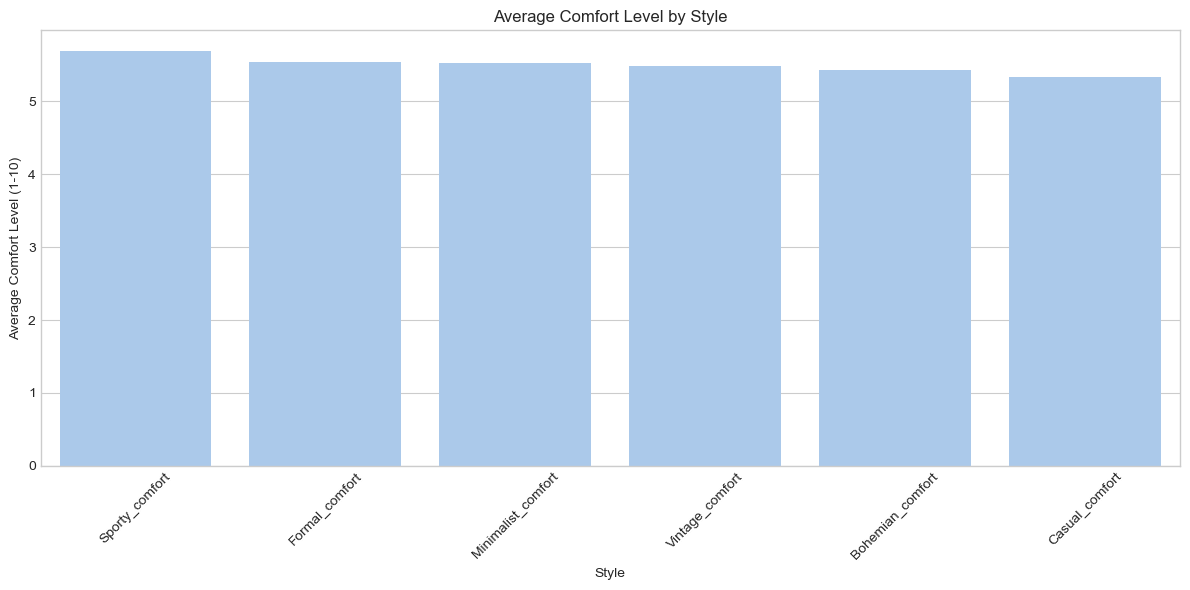

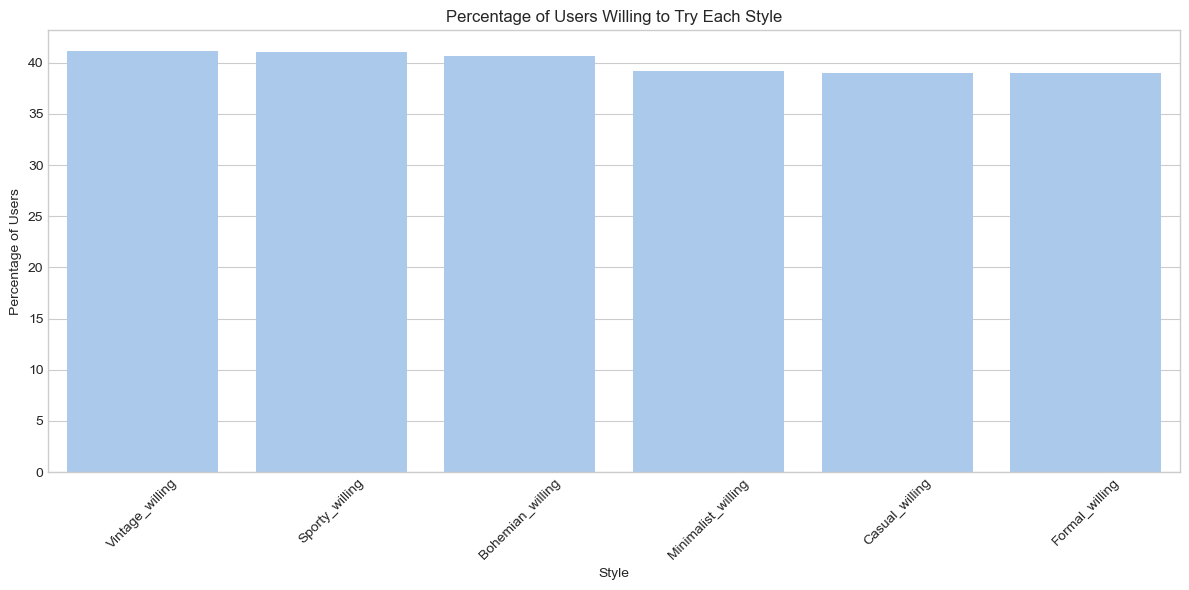

In [11]:
# Extract style preference columns
style_categories = ['Casual', 'Formal', 'Vintage', 'Sporty', 'Bohemian', 'Minimalist']
comfort_cols = [f'{style}_comfort' for style in style_categories]
willing_cols = [f'{style}_willing' for style in style_categories]
avoid_cols = [f'{style}_avoid' for style in style_categories]

# Visualize average comfort level for each style
plt.figure(figsize=(12, 6))
avg_comfort = users[comfort_cols].mean().sort_values(ascending=False)
sns.barplot(x=avg_comfort.index, y=avg_comfort.values)
plt.title('Average Comfort Level by Style')
plt.xlabel('Style')
plt.ylabel('Average Comfort Level (1-10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize percentage of users willing to try each style
plt.figure(figsize=(12, 6))
willing_pct = users[willing_cols].mean().sort_values(ascending=False) * 100
sns.barplot(x=willing_pct.index, y=willing_pct.values)
plt.title('Percentage of Users Willing to Try Each Style')
plt.xlabel('Style')
plt.ylabel('Percentage of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Multi-Armed Bandit Problem Definition for H&M Subscription Service

"""
In our H&M subscription service, we face the exploration-exploitation dilemma:
- Exploration: Trying new styles/items that the user might like but hasn't tried before
- Exploitation: Sending items that match the user's known preferences

For each user, we need to decide which styles to include in their subscription box.
Each style category (Casual, Formal, Vintage, etc.) represents an "arm" in our bandit problem.

The reward is defined as whether the user keeps the item (not returned) and gives positive feedback.
"""

# Define the arms (style categories)
arms = style_categories
print(f"Our multi-armed bandit has {len(arms)} arms (styles): {arms}")

# Define reward function
def get_reward(user_id, style, deliveries_df, products_df):
    """
    Calculate the reward for a given user and style based on past deliveries.
    Reward is 1 if the user kept the item and rated it 4-5, 0 otherwise.
    """
    # Get products of the given style
    style_products = products_df[products_df['style'] == style]['product_id'].tolist()
    
    # Get user's deliveries for this style
    user_style_deliveries = deliveries_df[
        (deliveries_df['user_id'] == user_id) & 
        (deliveries_df['product_id'].isin(style_products))
    ]
    
    if len(user_style_deliveries) == 0:
        return None  # No data for this user-style combination
    
    # Calculate reward: items kept (not returned) and highly rated (4-5)
    positive_outcomes = user_style_deliveries[
        (~user_style_deliveries['returned']) & 
        (user_style_deliveries['feedback_rating'].isin([4, 5]))
    ]
    
    if len(user_style_deliveries) > 0:
        return len(positive_outcomes) / len(user_style_deliveries)
    else:
        return None


Our multi-armed bandit has 6 arms (styles): ['Casual', 'Formal', 'Vintage', 'Sporty', 'Bohemian', 'Minimalist']


In [20]:
# Thompson Sampling Algorithm Implementation

class ThompsonSampling:
    def __init__(self, arms):
        self.arms = arms
        # Initialize alpha and beta parameters for Beta distribution
        # Alpha represents successful rewards, Beta represents failures
        self.alpha = {arm: 1 for arm in arms}
        self.beta = {arm: 1 for arm in arms}
    
    def select_arm(self):
        """
        Select an arm using Thompson Sampling strategy.
        Sample from Beta distribution for each arm and select the arm with highest sample.
        """
        samples = {arm: beta.rvs(self.alpha[arm], self.beta[arm]) for arm in self.arms}
        return max(samples, key=samples.get)
    
    def update(self, arm, reward):
        """
        Update the Beta distribution parameters for the selected arm.
        """
        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1
    
    def initialize_from_history(self, user_id, deliveries_df, products_df):
        """
        Initialize the bandit algorithm with historical data for a specific user.
        """
        for arm in self.arms:
            reward = get_reward(user_id, arm, deliveries_df, products_df)
            if reward is not None:
                # Add successful trials to alpha
                self.alpha[arm] += int(reward * 10)
                # Add unsuccessful trials to beta
                self.beta[arm] += int((1 - reward) * 10)

# Function to visualize Beta distributions
def plot_beta_distributions(thompson_sampler):
    plt.figure(figsize=(14, 8))
    x = np.linspace(0, 1, 1000)
    
    for arm in thompson_sampler.arms:
        y = beta.pdf(x, thompson_sampler.alpha[arm], thompson_sampler.beta[arm])
        plt.plot(x, y, label=f"{arm} (α={thompson_sampler.alpha[arm]:.1f}, β={thompson_sampler.beta[arm]:.1f})")
    
    plt.title('Beta Distributions for Each Style')
    plt.xlabel('Probability of Positive Reward')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
clothing_categories = ['Shirts', 'Pants', 'Dresses', 'Jackets', 'Accessories', 'Shoes']

def generate_subscription_box(user_id, thompson_sampler, products_df, num_items=5):
    """
    Generate a subscription box with 5 items for a user based on Thompson Sampling
    
    Parameters:
    - user_id: The user's ID
    - thompson_sampler: Initialized Thompson Sampling algorithm
    - products_df: DataFrame containing product information
    - num_items: Number of items to include in the subscription box (default: 5)
    
    Returns:
    - A DataFrame containing the items in the subscription box
    """
    # Get user's subscription tier
    user_row = users[users['user_id'] == user_id]
    if len(user_row) == 0:
        print(f"User {user_id} not found")
        return pd.DataFrame()
    
    subscription_tier = user_row['subscription_tier'].values[0]
    
    # Filter products by subscription tier and in-stock status
    available_products = products_df[
        (products_df['price_tier'] == subscription_tier) & 
        (products_df['in_stock'] == True)
    ]
    
    # Ensure we have different categories in the box (e.g., shirts, pants, etc.)
    subscription_box = pd.DataFrame()
    selected_categories = []
    
    # First, select styles using Thompson Sampling
    selected_styles = []
    for _ in range(min(num_items, len(thompson_sampler.arms))):
        # Select arm (style) using Thompson Sampling
        selected_style = thompson_sampler.select_arm()
        selected_styles.append(selected_style)
    
    # Count occurrences of each style
    style_counts = pd.Series(selected_styles).value_counts()
    
    # Now select products based on the selected styles
    for style, count in style_counts.items():
        # Filter products by style
        style_products = available_products[available_products['style'] == style]
        
        if len(style_products) == 0:
            continue
        
        # Try to select products from different categories
        for _ in range(min(count, len(style_products))):
            # Filter by categories not yet in the box
            remaining_categories = list(set(clothing_categories) - set(selected_categories))
            
            if remaining_categories:
                # Prioritize categories not yet in the box
                category_products = style_products[style_products['category'].isin(remaining_categories)]
                
                if len(category_products) > 0:
                    selected_product = category_products.sample(1)
                    selected_categories.append(selected_product['category'].values[0])
                else:
                    # If no products in remaining categories, just sample from style products
                    selected_product = style_products.sample(1)
                    selected_categories.append(selected_product['category'].values[0])
            else:
                # If all categories are used, just sample from style products
                selected_product = style_products.sample(1)
                selected_categories.append(selected_product['category'].values[0])
            
            # Add to subscription box
            subscription_box = pd.concat([subscription_box, selected_product])
            
            # Remove selected product from available products to avoid duplicates
            available_products = available_products[available_products['product_id'] != selected_product['product_id'].values[0]]
    
    # If we haven't selected enough items, add random products
    if len(subscription_box) < num_items:
        remaining = num_items - len(subscription_box)
        if len(available_products) >= remaining:
            additional_products = available_products.sample(remaining)
            subscription_box = pd.concat([subscription_box, additional_products])
    
    # Limit to num_items
    return subscription_box.head(num_items)


In [18]:
def simulate_user_feedback(user_id, product_id):
    """
    Simulate user feedback for a product.
    Returns 1 (positive) or 0 (negative) based on user's style preferences.
    """
    user_row = users[users['user_id'] == user_id].iloc[0]
    product_row = products[products['product_id'] == product_id].iloc[0]
    
    style = product_row['style']
    comfort_level = user_row[f'{style}_comfort']
    
    # Higher comfort level increases likelihood of positive feedback
    positive_probability = min(0.9, max(0.1, comfort_level / 10))
    
    return np.random.choice([1, 0], p=[positive_probability, 1-positive_probability])

def update_model_with_feedback(thompson_sampler, subscription_box, user_id):
    """
    Update the Thompson Sampling model with simulated user feedback.
    """
    for _, product in subscription_box.iterrows():
        style = product['style']
        product_id = product['product_id']
        
        # Simulate user feedback
        feedback = simulate_user_feedback(user_id, product_id)
        
        # Update the model
        thompson_sampler.update(style, feedback)
        
        # Print the feedback
        print(f"Product {product_id} ({product['category']}, {style}): {'👍 Kept' if feedback == 1 else '👎 Returned'}")


User ID: 42
Gender: Female
Age: 50
Subscription Tier: Budget

Style Preferences (Comfort Level 1-10):
- Casual: 5
- Formal: 7
- Vintage: 10
- Sporty: 10
- Bohemian: 6
- Minimalist: 5

Initial style preference distributions based on historical data:


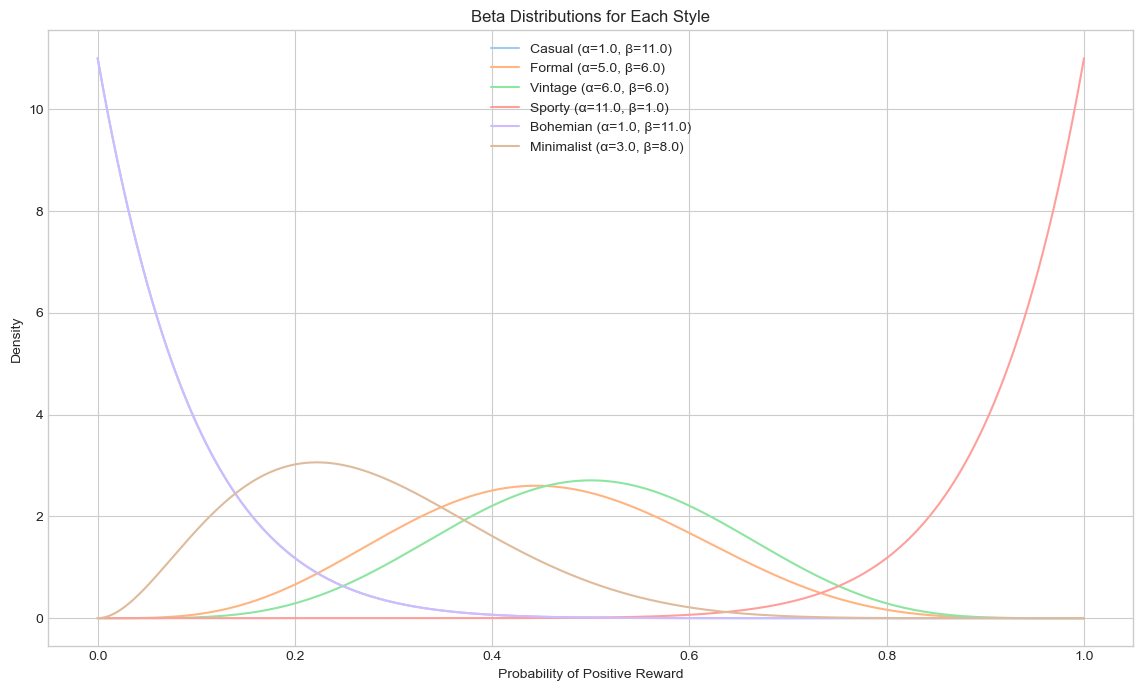


🎁 Month 1 Subscription Box:
     product_id     category   style   color price_tier  price
433         434        Shoes  Sporty     Red     Budget     13
88           89        Pants  Sporty    Pink     Budget     16
30           31       Shirts  Sporty  Yellow     Budget     18
270         271      Dresses  Sporty     Red     Budget     10
162         163  Accessories  Sporty   White     Budget     19

User Feedback for Month 1:
Product 434 (Shoes, Sporty): 👍 Kept
Product 89 (Pants, Sporty): 👍 Kept
Product 31 (Shirts, Sporty): 👍 Kept
Product 271 (Dresses, Sporty): 👎 Returned
Product 163 (Accessories, Sporty): 👍 Kept

Updated style preference distributions after Month 1 feedback:


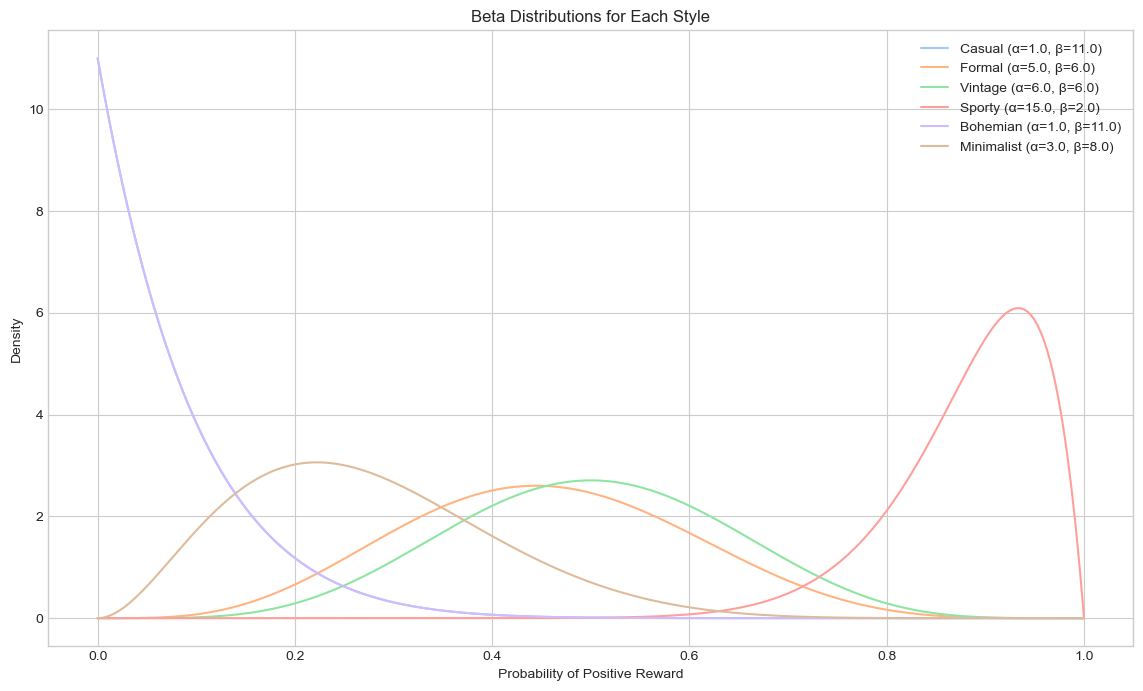


🎁 Month 2 Subscription Box:
     product_id     category   style   color price_tier  price
400         401        Pants  Sporty  Yellow     Budget     15
89           90       Shirts  Sporty    Blue     Budget     29
421         422        Shoes  Sporty   Green     Budget     28
492         493      Dresses  Sporty     Red     Budget     17
130         131  Accessories  Sporty   Brown     Budget     27

User Feedback for Month 2:
Product 401 (Pants, Sporty): 👍 Kept
Product 90 (Shirts, Sporty): 👍 Kept
Product 422 (Shoes, Sporty): 👍 Kept
Product 493 (Dresses, Sporty): 👍 Kept
Product 131 (Accessories, Sporty): 👍 Kept

Updated style preference distributions after Month 2 feedback:


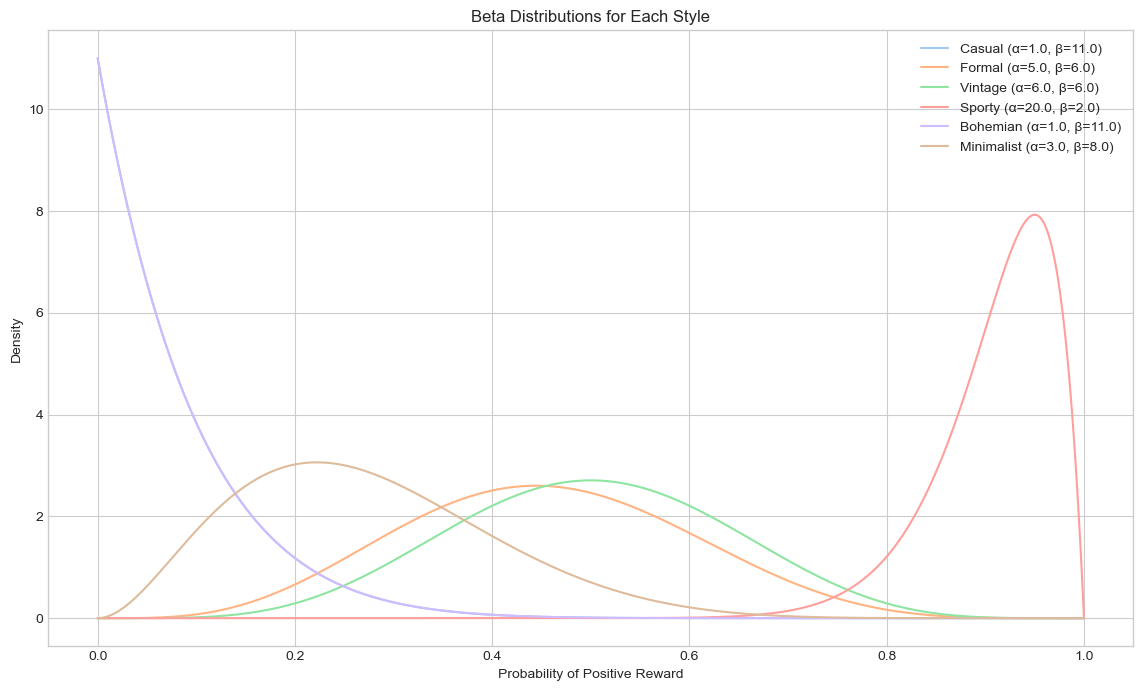

In [23]:
# Select a sample user
sample_user_id = 42

# Initialize Thompson Sampling for the user
ts = ThompsonSampling(arms)
ts.initialize_from_history(sample_user_id, deliveries, products)

# Display user information
user_info = users[users['user_id'] == sample_user_id].iloc[0]
print(f"User ID: {sample_user_id}")
print(f"Gender: {user_info['gender']}")
print(f"Age: {user_info['age']}")
print(f"Subscription Tier: {user_info['subscription_tier']}")
print("\nStyle Preferences (Comfort Level 1-10):")
for style in style_categories:
    print(f"- {style}: {user_info[f'{style}_comfort']}")

# Visualize initial Beta distributions
print("\nInitial style preference distributions based on historical data:")
plot_beta_distributions(ts)

# Generate first subscription box
print("\n🎁 Month 1 Subscription Box:")
month1_box = generate_subscription_box(sample_user_id, ts, products)
print(month1_box[['product_id', 'category', 'style', 'color', 'price_tier', 'price']])

# Simulate user feedback and update model
print("\nUser Feedback for Month 1:")
update_model_with_feedback(ts, month1_box, sample_user_id)

# Visualize updated Beta distributions
print("\nUpdated style preference distributions after Month 1 feedback:")
plot_beta_distributions(ts)

# Generate second subscription box
print("\n🎁 Month 2 Subscription Box:")
month2_box = generate_subscription_box(sample_user_id, ts, products)
print(month2_box[['product_id', 'category', 'style', 'color', 'price_tier', 'price']])

# Simulate user feedback and update model
print("\nUser Feedback for Month 2:")
update_model_with_feedback(ts, month2_box, sample_user_id)

# Visualize final Beta distributions
print("\nUpdated style preference distributions after Month 2 feedback:")
plot_beta_distributions(ts)


Product 54 (Shirts, Sporty): 👍 Kept
Product 86 (Accessories, Sporty): 👍 Kept
Product 313 (Pants, Sporty): 👍 Kept
Product 493 (Dresses, Sporty): 👍 Kept
Product 385 (Shoes, Sporty): 👍 Kept
Product 309 (Shoes, Sporty): 👎 Returned
Product 90 (Shirts, Sporty): 👍 Kept
Product 254 (Pants, Sporty): 👍 Kept
Product 163 (Accessories, Sporty): 👍 Kept
Product 493 (Dresses, Sporty): 👍 Kept
Product 422 (Shoes, Sporty): 👍 Kept
Product 54 (Shirts, Sporty): 👍 Kept
Product 243 (Jackets, Sporty): 👍 Kept
Product 493 (Dresses, Sporty): 👍 Kept
Product 401 (Pants, Sporty): 👍 Kept
Product 163 (Accessories, Sporty): 👍 Kept
Product 385 (Shoes, Sporty): 👍 Kept
Product 99 (Shirts, Sporty): 👎 Returned
Product 426 (Jackets, Sporty): 👍 Kept
Product 254 (Pants, Sporty): 👍 Kept
Product 434 (Shoes, Sporty): 👍 Kept
Product 470 (Pants, Sporty): 👍 Kept
Product 426 (Jackets, Sporty): 👍 Kept
Product 125 (Accessories, Sporty): 👍 Kept
Product 31 (Shirts, Sporty): 👎 Returned
Product 90 (Shirts, Sporty): 👍 Kept
Product 401 (Pant

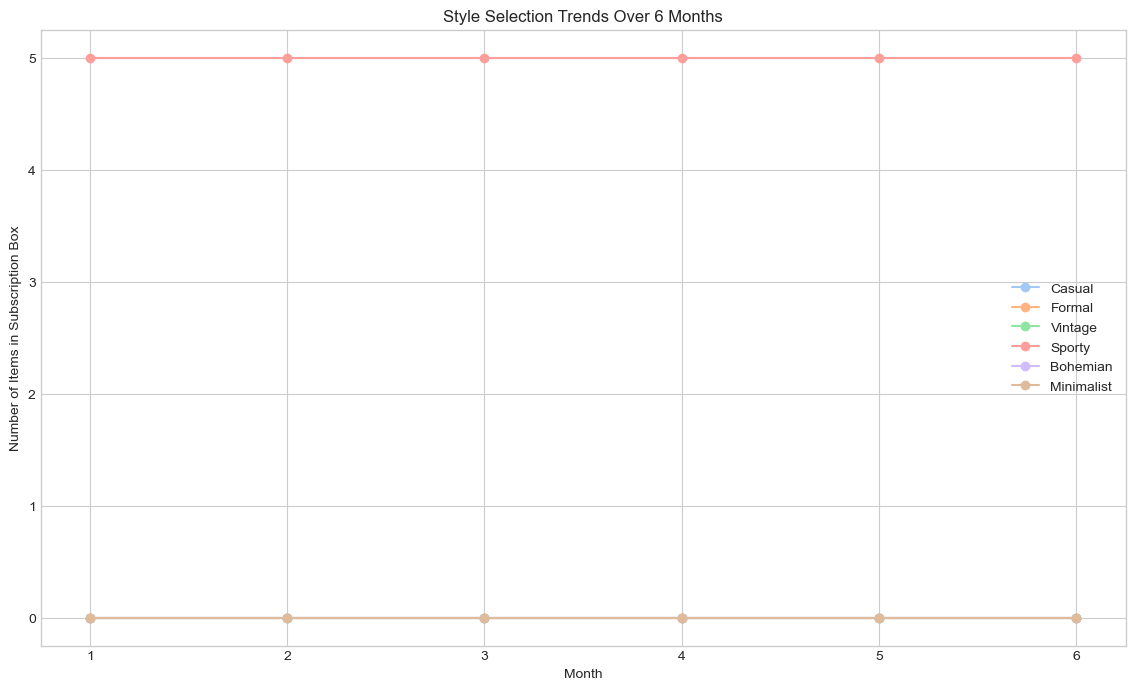

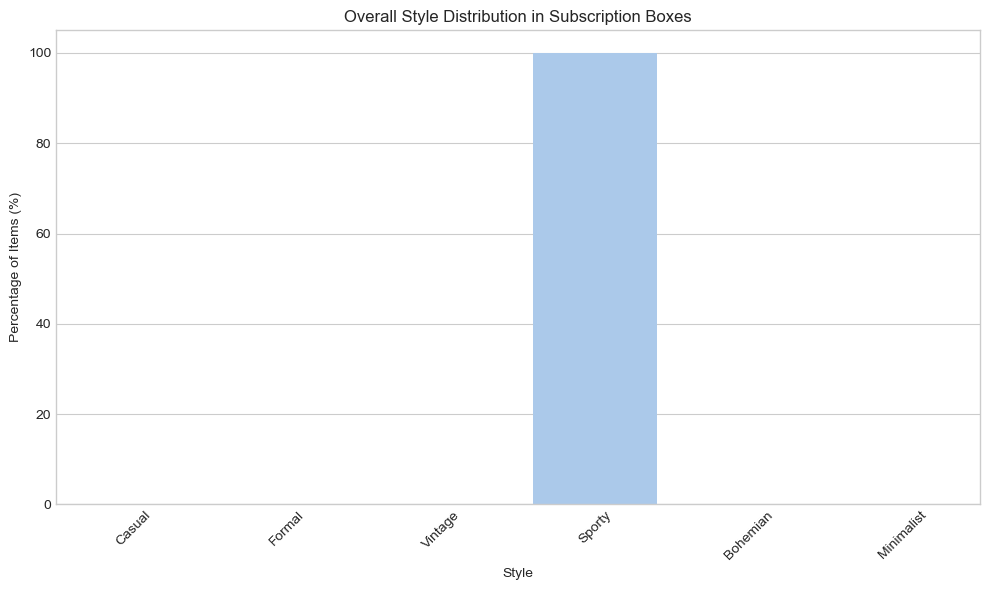

In [24]:
# Simulate subscription boxes over 6 months
num_months = 6
ts_long_term = ThompsonSampling(arms)
ts_long_term.initialize_from_history(sample_user_id, deliveries, products)

# Track style selections over time
style_selections = {style: [] for style in style_categories}

for month in range(1, num_months + 1):
    # Generate subscription box
    monthly_box = generate_subscription_box(sample_user_id, ts_long_term, products)
    
    # Count styles in the box
    month_styles = monthly_box['style'].value_counts().to_dict()
    
    # Update style selections tracking
    for style in style_categories:
        style_selections[style].append(month_styles.get(style, 0))
    
    # Simulate feedback and update model
    update_model_with_feedback(ts_long_term, monthly_box, sample_user_id)

# Visualize style selection trends
plt.figure(figsize=(14, 8))
months = list(range(1, num_months + 1))

for style in style_categories:
    plt.plot(months, style_selections[style], marker='o', label=style)

plt.title('Style Selection Trends Over 6 Months')
plt.xlabel('Month')
plt.ylabel('Number of Items in Subscription Box')
plt.xticks(months)
plt.legend()
plt.grid(True)
plt.show()

# Calculate final style distribution
final_distribution = {style: sum(counts) for style, counts in style_selections.items()}
total_items = sum(final_distribution.values())
final_percentages = {style: (count/total_items)*100 for style, count in final_distribution.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(final_percentages.keys()), y=list(final_percentages.values()))
plt.title('Overall Style Distribution in Subscription Boxes')
plt.xlabel('Style')
plt.ylabel('Percentage of Items (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


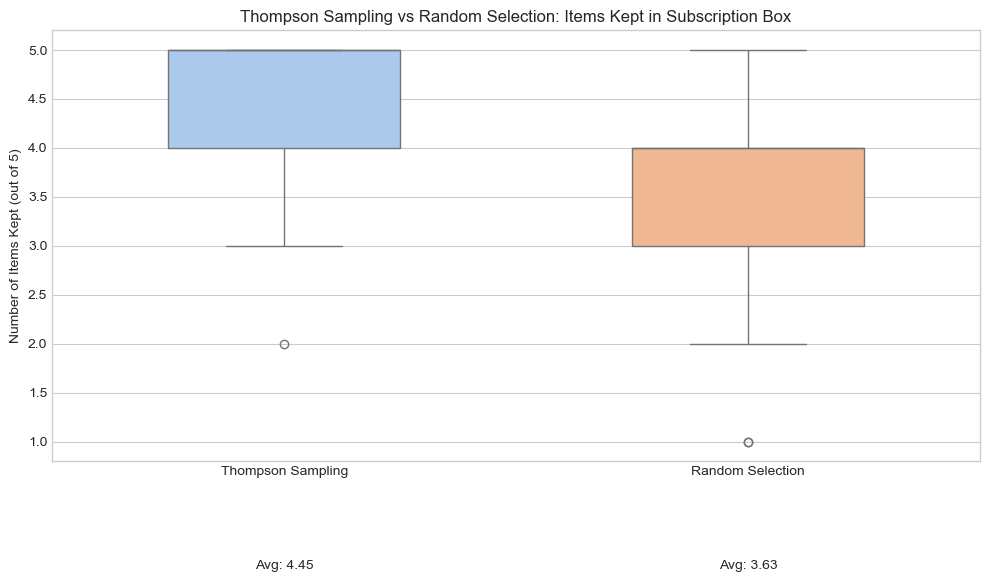

In [25]:
# Compare Thompson Sampling with random selection
def random_selection(user_id, products_df, num_items=5):
    """
    Generate a subscription box with random selection
    """
    user_row = users[users['user_id'] == user_id]
    subscription_tier = user_row['subscription_tier'].values[0]
    
    available_products = products_df[
        (products_df['price_tier'] == subscription_tier) & 
        (products_df['in_stock'] == True)
    ]
    
    if len(available_products) >= num_items:
        return available_products.sample(num_items)
    else:
        return available_products

# Run simulation comparing Thompson Sampling vs Random
num_simulations = 100
ts_rewards = []
random_rewards = []

for _ in range(num_simulations):
    # Initialize Thompson Sampling
    ts_sim = ThompsonSampling(arms)
    ts_sim.initialize_from_history(sample_user_id, deliveries, products)
    
    # Generate boxes and collect rewards
    ts_box = generate_subscription_box(sample_user_id, ts_sim, products)
    random_box = random_selection(sample_user_id, products)
    
    # Calculate rewards
    ts_reward = sum(simulate_user_feedback(sample_user_id, product_id) 
                    for product_id in ts_box['product_id'])
    random_reward = sum(simulate_user_feedback(sample_user_id, product_id) 
                         for product_id in random_box['product_id'])
    
    ts_rewards.append(ts_reward)
    random_rewards.append(random_reward)

# Calculate average rewards
avg_ts_reward = sum(ts_rewards) / len(ts_rewards)
avg_random_reward = sum(random_rewards) / len(random_rewards)

# Visualize comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=[ts_rewards, random_rewards], width=0.5)
plt.xticks([0, 1], ['Thompson Sampling', 'Random Selection'])
plt.ylabel('Number of Items Kept (out of 5)')
plt.title('Thompson Sampling vs Random Selection: Items Kept in Subscription Box')

plt.text(0, -0.3, f'Avg: {avg_ts_reward:.2f}', ha='center')
plt.text(1, -0.3, f'Avg: {avg_random_reward:.2f}', ha='center')

plt.tight_layout()
plt.show()
